In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

In [4]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'Locus tag', 'Protein accession', 'Name', 'Symbol'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [5]:
k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]

res_desired = data_gene.uns["BacSC_params"]["res_opt"]
print(res_desired)

Optimal number of PCs:4


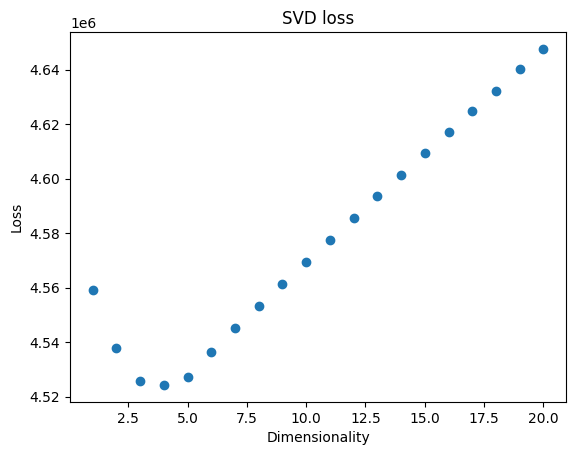

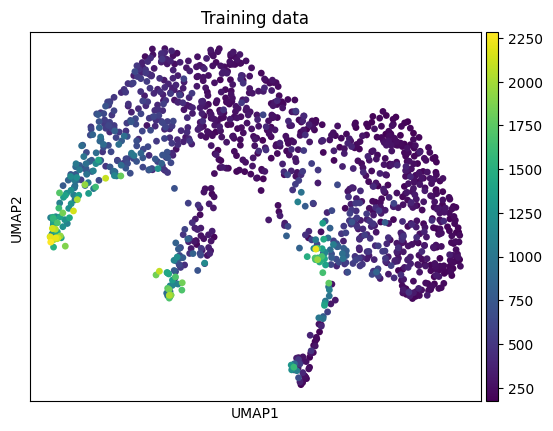

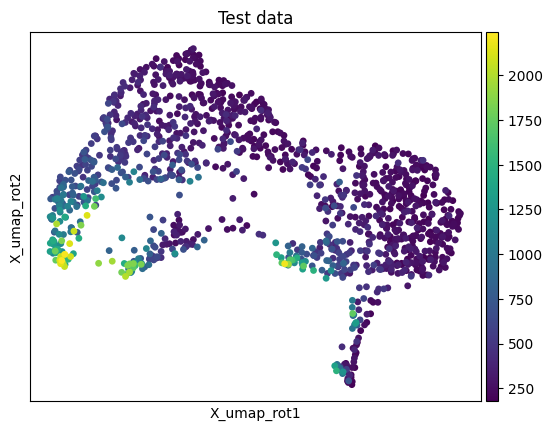

In [6]:
is_overdispersed = False
data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)

# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

In [7]:
res_opt = 0.
while res_opt != res_desired:
    rng = np.random.default_rng()
    seed = rng.choice(1000)
    print(seed)

    importlib.reload(co)
    res_min = 0.01
    res_max = 0.5
    res_step = 0.02
    resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

    co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=seed)

    mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=seed)

    print(f"Optimal resolution {res_opt}")


723
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.226
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.445 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.197
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.19
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.396 - Random: 0.141
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.387 - Random: 0.134
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random: 0.126
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.36 - Random: 0.082
resolution: 0.23 - clusters: 5 - Train: 0.381 - Test: 0.361 - Random: 0.082
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.354 - Random: 0.077
resolution: 0.27 -

resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.132
resolution: 0.19 - clusters: 5 - Train: 0.394 - Test: 0.374 - Random: 0.093
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.36 - Random: 0.083
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random: 0.076
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.079
resolution: 0.27 - clusters: 5 - Train: 0.368 - Test: 0.343 - Random: 0.065
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.059
resolution: 0.31 - clusters: 5 - Train: 0.357 - Test: 0.334 - Random: 0.057
resolution: 0.33 - clusters: 5 - Train: 0.351 - Test: 0.328 - Random: 0.05
resolution: 0.35 - clusters: 5 - Train: 0.344 - Test: 0.318 - Random: 0.043
resolution: 0.37 - clusters: 6 - Train: 0.342 - Test: 0.29 - Random: 0.029
resolution: 0.39 - clusters: 5 - Train: 0.334 - Test: 0.297 - Random: 0.03
resolution: 0.41 - clusters: 6 - Train: 0.331 - Test: 0.286 - Random: 0.021
resolution: 0.43 -

resolution: 0.31 - clusters: 6 - Train: 0.356 - Test: 0.311 - Random: 0.052
resolution: 0.33 - clusters: 5 - Train: 0.35 - Test: 0.33 - Random: 0.052
resolution: 0.35 - clusters: 5 - Train: 0.344 - Test: 0.324 - Random: 0.046
resolution: 0.37 - clusters: 6 - Train: 0.339 - Test: 0.287 - Random: 0.033
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.028
resolution: 0.41 - clusters: 5 - Train: 0.33 - Test: 0.293 - Random: 0.022
resolution: 0.43 - clusters: 6 - Train: 0.331 - Test: 0.287 - Random: 0.015
resolution: 0.45 - clusters: 6 - Train: 0.317 - Test: 0.285 - Random: 0.015
resolution: 0.47 - clusters: 7 - Train: 0.321 - Test: 0.278 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.322 - Test: 0.255 - Random: 0.001
Optimal resolution 0.21
293
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.472 - Test: 0.466 - Random: 0.237
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Rand

resolution: 0.45 - clusters: 7 - Train: 0.326 - Test: 0.283 - Random: 0.01
resolution: 0.47 - clusters: 6 - Train: 0.322 - Test: 0.278 - Random: 0.007
resolution: 0.49 - clusters: 7 - Train: 0.315 - Test: 0.262 - Random: 0.003
Optimal resolution 0.31
439
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.227
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.445 - Random: 0.219
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.206
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.199
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.189
resolution: 0.15 - clusters: 3 - Train: 0.41 - Test: 0.398 - Random: 0.152
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.133
resolution: 0.19 - clusters: 5 - Train: 0.395 - Test: 0.367 - Random: 

resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.433 - Random: 0.209
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.199
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.186
resolution: 0.15 - clusters: 4 - Train: 0.407 - Test: 0.393 - Random: 0.143
resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.384 - Random: 0.132
resolution: 0.19 - clusters: 5 - Train: 0.393 - Test: 0.37 - Random: 0.094
resolution: 0.21 - clusters: 5 - Train: 0.388 - Test: 0.368 - Random: 0.09
resolution: 0.23 - clusters: 5 - Train: 0.381 - Test: 0.359 - Random: 0.083
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.355 - Random: 0.074
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.342 - Random: 0.065
resolution: 0.29 - clusters: 5 - Train: 0.362 - Test: 0.343 - Random: 0.065
resolution: 0.31 - clusters: 5 - Train: 0.357 - Test: 0.338 - Random: 0.055
resolution: 0.33 - clusters: 5 - Train: 0.35 - Test: 0.33 - Random: 0.053
resolution: 0.35

resolution: 0.23 - clusters: 5 - Train: 0.381 - Test: 0.361 - Random: 0.085
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.077
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.349 - Random: 0.071
resolution: 0.29 - clusters: 5 - Train: 0.363 - Test: 0.343 - Random: 0.063
resolution: 0.31 - clusters: 5 - Train: 0.357 - Test: 0.338 - Random: 0.056
resolution: 0.33 - clusters: 5 - Train: 0.351 - Test: 0.331 - Random: 0.051
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.322 - Random: 0.044
resolution: 0.37 - clusters: 5 - Train: 0.338 - Test: 0.319 - Random: 0.04
resolution: 0.39 - clusters: 5 - Train: 0.334 - Test: 0.307 - Random: 0.031
resolution: 0.41 - clusters: 6 - Train: 0.333 - Test: 0.28 - Random: 0.019
resolution: 0.43 - clusters: 6 - Train: 0.329 - Test: 0.275 - Random: 0.015
resolution: 0.45 - clusters: 6 - Train: 0.326 - Test: 0.283 - Random: 0.01
resolution: 0.47 - clusters: 6 - Train: 0.319 - Test: 0.265 - Random: 0.006
resolution: 0.4

resolution: 0.37 - clusters: 5 - Train: 0.342 - Test: 0.313 - Random: 0.036
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.028
resolution: 0.41 - clusters: 5 - Train: 0.334 - Test: 0.296 - Random: 0.021
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.017
resolution: 0.45 - clusters: 6 - Train: 0.326 - Test: 0.283 - Random: 0.011
resolution: 0.47 - clusters: 7 - Train: 0.322 - Test: 0.254 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.317 - Test: 0.273 - Random: 0.002
Optimal resolution 0.27
117
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.455 - Random: 0.228
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.218
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Rand

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.228
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.215
resolution: 0.09 - clusters: 2 - Train: 0.442 - Test: 0.434 - Random: 0.206
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.195
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.187
resolution: 0.15 - clusters: 4 - Train: 0.406 - Test: 0.395 - Random: 0.147
resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.386 - Random: 0.131
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.124
resolution: 0.21 - clusters: 5 - Train: 0.388 - Test: 0.367 - Random: 0.09
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.353 - Random: 0.075
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.071
resolution: 0.27 - 

resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.385 - Random: 0.133
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.125
resolution: 0.21 - clusters: 4 - Train: 0.383 - Test: 0.369 - Random: 0.117
resolution: 0.23 - clusters: 5 - Train: 0.38 - Test: 0.356 - Random: 0.082
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.074
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.349 - Random: 0.071
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.059
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.333 - Random: 0.053
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.048
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.043
resolution: 0.37 - clusters: 5 - Train: 0.343 - Test: 0.306 - Random: 0.036
resolution: 0.39 - clusters: 5 - Train: 0.333 - Test: 0.302 - Random: 0.031
resolution: 0.41 - clusters: 6 - Train: 0.333 - Test: 0.281 - Random: 0.019
resolution: 0.

resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.333 - Random: 0.052
resolution: 0.33 - clusters: 5 - Train: 0.351 - Test: 0.331 - Random: 0.051
resolution: 0.35 - clusters: 5 - Train: 0.345 - Test: 0.325 - Random: 0.045
resolution: 0.37 - clusters: 5 - Train: 0.342 - Test: 0.313 - Random: 0.035
resolution: 0.39 - clusters: 5 - Train: 0.334 - Test: 0.307 - Random: 0.029
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.298 - Random: 0.022
resolution: 0.43 - clusters: 6 - Train: 0.33 - Test: 0.284 - Random: 0.015
resolution: 0.45 - clusters: 7 - Train: 0.329 - Test: 0.276 - Random: 0.008
resolution: 0.47 - clusters: 7 - Train: 0.326 - Test: 0.258 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.322 - Test: 0.255 - Random: 0.002
Optimal resolution 0.31
218
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random

resolution: 0.45 - clusters: 7 - Train: 0.332 - Test: 0.275 - Random: 0.009
resolution: 0.47 - clusters: 6 - Train: 0.322 - Test: 0.277 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.317 - Test: 0.273 - Random: 0.002
Optimal resolution 0.29
253
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.228
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.218
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.208
resolution: 0.11 - clusters: 2 - Train: 0.431 - Test: 0.423 - Random: 0.199
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.187
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.396 - Random: 0.141
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.133
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random

resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.197
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.188
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.394 - Random: 0.143
resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.386 - Random: 0.132
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.123
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.359 - Random: 0.082
resolution: 0.23 - clusters: 5 - Train: 0.382 - Test: 0.362 - Random: 0.082
resolution: 0.25 - clusters: 5 - Train: 0.376 - Test: 0.348 - Random: 0.07
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.345 - Random: 0.065
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.061
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.053
resolution: 0.33 - clusters: 6 - Train: 0.35 - Test: 0.306 - Random: 0.048
resolution: 0.35

resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random: 0.075
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.071
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.342 - Random: 0.063
resolution: 0.29 - clusters: 5 - Train: 0.361 - Test: 0.342 - Random: 0.065
resolution: 0.31 - clusters: 5 - Train: 0.356 - Test: 0.33 - Random: 0.056
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.049
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.042
resolution: 0.37 - clusters: 5 - Train: 0.342 - Test: 0.313 - Random: 0.035
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.029
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.023
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.017
resolution: 0.45 - clusters: 7 - Train: 0.325 - Test: 0.271 - Random: 0.009
resolution: 0.47 - clusters: 7 - Train: 0.328 - Test: 0.271 - Random: 0.007
resolution: 0

resolution: 0.37 - clusters: 5 - Train: 0.343 - Test: 0.306 - Random: 0.033
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.028
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.297 - Random: 0.021
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.018
resolution: 0.45 - clusters: 7 - Train: 0.332 - Test: 0.275 - Random: 0.009
resolution: 0.47 - clusters: 7 - Train: 0.321 - Test: 0.269 - Random: 0.007
resolution: 0.49 - clusters: 7 - Train: 0.316 - Test: 0.262 - Random: 0.001
Optimal resolution 0.25
130
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.228
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.216
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.208
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Rand

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.472 - Test: 0.466 - Random: 0.238
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.455 - Random: 0.225
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.218
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.187
resolution: 0.15 - clusters: 3 - Train: 0.409 - Test: 0.399 - Random: 0.151
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.131
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random: 0.127
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.363 - Random: 0.084
resolution: 0.23 - clusters: 5 - Train: 0.382 - Test: 0.362 - Random: 0.082
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.351 - Random: 0.073
resolution: 0.27 

resolution: 0.15 - clusters: 3 - Train: 0.41 - Test: 0.398 - Random: 0.155
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.135
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.123
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.36 - Random: 0.085
resolution: 0.23 - clusters: 5 - Train: 0.381 - Test: 0.36 - Random: 0.083
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.354 - Random: 0.077
resolution: 0.27 - clusters: 5 - Train: 0.368 - Test: 0.348 - Random: 0.072
resolution: 0.29 - clusters: 5 - Train: 0.362 - Test: 0.343 - Random: 0.066
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.053
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.047
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.312 - Random: 0.039
resolution: 0.37 - clusters: 6 - Train: 0.341 - Test: 0.297 - Random: 0.032
resolution: 0.39 - clusters: 5 - Train: 0.339 - Test: 0.302 - Random: 0.027
resolution: 0.41 - 

resolution: 0.31 - clusters: 5 - Train: 0.357 - Test: 0.334 - Random: 0.056
resolution: 0.33 - clusters: 5 - Train: 0.35 - Test: 0.324 - Random: 0.047
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.041
resolution: 0.37 - clusters: 5 - Train: 0.343 - Test: 0.306 - Random: 0.035
resolution: 0.39 - clusters: 6 - Train: 0.338 - Test: 0.285 - Random: 0.024
resolution: 0.41 - clusters: 6 - Train: 0.333 - Test: 0.281 - Random: 0.02
resolution: 0.43 - clusters: 7 - Train: 0.332 - Test: 0.26 - Random: 0.012
resolution: 0.45 - clusters: 7 - Train: 0.328 - Test: 0.262 - Random: 0.01
resolution: 0.47 - clusters: 6 - Train: 0.323 - Test: 0.275 - Random: 0.007
resolution: 0.49 - clusters: 7 - Train: 0.32 - Test: 0.258 - Random: 0.002
Optimal resolution 0.21
877
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0

resolution: 0.47 - clusters: 7 - Train: 0.328 - Test: 0.271 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.316 - Test: 0.263 - Random: 0.003
Optimal resolution 0.23
506
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.226
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.435 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.199
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.187
resolution: 0.15 - clusters: 4 - Train: 0.406 - Test: 0.395 - Random: 0.143
resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.386 - Random: 0.129
resolution: 0.19 - clusters: 5 - Train: 0.394 - Test: 0.374 - Random: 0.094
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.363 - Rand

resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.197
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.408 - Random: 0.159
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.395 - Random: 0.143
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.133
resolution: 0.19 - clusters: 5 - Train: 0.394 - Test: 0.374 - Random: 0.093
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.362 - Random: 0.086
resolution: 0.23 - clusters: 5 - Train: 0.382 - Test: 0.362 - Random: 0.083
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.074
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.345 - Random: 0.065
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.339 - Random: 0.06
resolution: 0.31 - clusters: 5 - Train: 0.357 - Test: 0.337 - Random: 0.058
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.328 - Random: 0.049
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.322 - Random: 0.042
resolution: 0.3

resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.072
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.353 - Random: 0.07
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.06
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.054
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.328 - Random: 0.049
resolution: 0.35 - clusters: 5 - Train: 0.344 - Test: 0.321 - Random: 0.047
resolution: 0.37 - clusters: 5 - Train: 0.344 - Test: 0.307 - Random: 0.034
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.027
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.021
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.017
resolution: 0.45 - clusters: 5 - Train: 0.323 - Test: 0.286 - Random: 0.013
resolution: 0.47 - clusters: 6 - Train: 0.322 - Test: 0.278 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.324 - Test: 0.267 - Random: 0.002
Optimal resoluti

resolution: 0.41 - clusters: 5 - Train: 0.326 - Test: 0.3 - Random: 0.025
resolution: 0.43 - clusters: 5 - Train: 0.329 - Test: 0.291 - Random: 0.017
resolution: 0.45 - clusters: 7 - Train: 0.332 - Test: 0.276 - Random: 0.008
resolution: 0.47 - clusters: 7 - Train: 0.328 - Test: 0.27 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.323 - Test: 0.265 - Random: 0.001
Optimal resolution 0.25
398
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.225
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.216
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.187
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.396 - Random:

resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.455 - Random: 0.227
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.445 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.437 - Test: 0.423 - Random: 0.204
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.197
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.407 - Random: 0.163
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.395 - Random: 0.144
resolution: 0.17 - clusters: 4 - Train: 0.398 - Test: 0.386 - Random: 0.138
resolution: 0.19 - clusters: 5 - Train: 0.395 - Test: 0.366 - Random: 0.09
resolution: 0.21 - clusters: 4 - Train: 0.383 - Test: 0.37 - Random: 0.115
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random: 0.076
resolution: 0.25 - clusters: 5 - Train: 0.369 - Test: 0.342 - Random: 0.078
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.342 - Random: 0.067
resolution: 0.29 - clusters: 6 - Train: 0.361 - Test: 0.318 - Random: 0.056
resolution: 0.

resolution: 0.21 - clusters: 5 - Train: 0.386 - Test: 0.367 - Random: 0.1
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.356 - Random: 0.08
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.351 - Random: 0.072
resolution: 0.27 - clusters: 5 - Train: 0.366 - Test: 0.347 - Random: 0.077
resolution: 0.29 - clusters: 5 - Train: 0.362 - Test: 0.339 - Random: 0.06
resolution: 0.31 - clusters: 5 - Train: 0.356 - Test: 0.33 - Random: 0.056
resolution: 0.33 - clusters: 5 - Train: 0.35 - Test: 0.324 - Random: 0.048
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.043
resolution: 0.37 - clusters: 5 - Train: 0.338 - Test: 0.311 - Random: 0.037
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.027
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.02
resolution: 0.43 - clusters: 7 - Train: 0.328 - Test: 0.254 - Random: 0.013
resolution: 0.45 - clusters: 7 - Train: 0.324 - Test: 0.25 - Random: 0.008
resolution: 0.47 - c

resolution: 0.37 - clusters: 5 - Train: 0.34 - Test: 0.312 - Random: 0.035
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.029
resolution: 0.41 - clusters: 5 - Train: 0.334 - Test: 0.296 - Random: 0.022
resolution: 0.43 - clusters: 6 - Train: 0.328 - Test: 0.277 - Random: 0.015
resolution: 0.45 - clusters: 6 - Train: 0.324 - Test: 0.272 - Random: 0.011
resolution: 0.47 - clusters: 7 - Train: 0.325 - Test: 0.26 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.322 - Test: 0.255 - Random: 0.002
Optimal resolution 0.25
925
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.229
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.218
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.206
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.455 - Random: 0.227
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.218
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.206
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 3 - Train: 0.419 - Test: 0.41 - Random: 0.178
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.396 - Random: 0.14
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.133
resolution: 0.19 - clusters: 5 - Train: 0.395 - Test: 0.366 - Random: 0.09
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.36 - Random: 0.085
resolution: 0.23 - clusters: 5 - Train: 0.382 - Test: 0.362 - Random: 0.081
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.069
resolution: 0.27 - clust

resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.385 - Random: 0.131
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.124
resolution: 0.21 - clusters: 4 - Train: 0.386 - Test: 0.368 - Random: 0.1
resolution: 0.23 - clusters: 5 - Train: 0.381 - Test: 0.362 - Random: 0.082
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.355 - Random: 0.074
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.35 - Random: 0.068
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.339 - Random: 0.059
resolution: 0.31 - clusters: 5 - Train: 0.356 - Test: 0.34 - Random: 0.059
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.328 - Random: 0.051
resolution: 0.35 - clusters: 5 - Train: 0.345 - Test: 0.325 - Random: 0.045
resolution: 0.37 - clusters: 6 - Train: 0.342 - Test: 0.288 - Random: 0.031
resolution: 0.39 - clusters: 6 - Train: 0.337 - Test: 0.284 - Random: 0.024
resolution: 0.41 - clusters: 6 - Train: 0.33 - Test: 0.285 - Random: 0.023
resolution: 0.43 

resolution: 0.31 - clusters: 5 - Train: 0.357 - Test: 0.338 - Random: 0.057
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.047
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.04
resolution: 0.37 - clusters: 5 - Train: 0.343 - Test: 0.306 - Random: 0.033
resolution: 0.39 - clusters: 6 - Train: 0.336 - Test: 0.29 - Random: 0.026
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.023
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.017
resolution: 0.45 - clusters: 5 - Train: 0.323 - Test: 0.286 - Random: 0.012
resolution: 0.47 - clusters: 7 - Train: 0.321 - Test: 0.277 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.315 - Test: 0.262 - Random: 0.001
Optimal resolution 0.29
873
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.455 - Random

resolution: 0.45 - clusters: 6 - Train: 0.326 - Test: 0.283 - Random: 0.01
resolution: 0.47 - clusters: 6 - Train: 0.319 - Test: 0.265 - Random: 0.007
resolution: 0.49 - clusters: 7 - Train: 0.315 - Test: 0.257 - Random: 0.003
Optimal resolution 0.27
622
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.227
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.219
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.194
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.406 - Random: 0.163
resolution: 0.15 - clusters: 3 - Train: 0.409 - Test: 0.396 - Random: 0.155
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.387 - Random: 0.138
resolution: 0.19 - clusters: 4 - Train: 0.389 - Test: 0.377 - Random:

resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.407 - Random: 0.161
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.395 - Random: 0.143
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.387 - Random: 0.137
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random: 0.127
resolution: 0.21 - clusters: 5 - Train: 0.387 - Test: 0.368 - Random: 0.103
resolution: 0.23 - clusters: 5 - Train: 0.382 - Test: 0.362 - Random: 0.084
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.354 - Random: 0.076
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.35 - Random: 0.07
resolution: 0.29 - clusters: 5 - Train: 0.363 - Test: 0.344 - Random: 0.062
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.054
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.047
resolution: 0.35 -

resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random: 0.076
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.075
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.35 - Random: 0.069
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.059
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.055
resolution: 0.33 - clusters: 5 - Train: 0.351 - Test: 0.329 - Random: 0.05
resolution: 0.35 - clusters: 5 - Train: 0.345 - Test: 0.325 - Random: 0.045
resolution: 0.37 - clusters: 5 - Train: 0.343 - Test: 0.306 - Random: 0.031
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.027
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.023
resolution: 0.43 - clusters: 6 - Train: 0.331 - Test: 0.287 - Random: 0.017
resolution: 0.45 - clusters: 7 - Train: 0.332 - Test: 0.275 - Random: 0.009
resolution: 0.47 - clusters: 7 - Train: 0.328 - Test: 0.27 - Random: 0.004
resolution: 0.49 

resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.304 - Random: 0.026
resolution: 0.41 - clusters: 5 - Train: 0.328 - Test: 0.297 - Random: 0.023
resolution: 0.43 - clusters: 5 - Train: 0.323 - Test: 0.295 - Random: 0.02
resolution: 0.45 - clusters: 7 - Train: 0.329 - Test: 0.257 - Random: 0.009
resolution: 0.47 - clusters: 7 - Train: 0.326 - Test: 0.259 - Random: 0.003
resolution: 0.49 - clusters: 7 - Train: 0.317 - Test: 0.273 - Random: 0.004
Optimal resolution 0.33
326
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.227
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.216
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.208
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.199
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Rando

resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.226
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.215
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.208
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.407 - Random: 0.163
resolution: 0.15 - clusters: 3 - Train: 0.41 - Test: 0.398 - Random: 0.153
resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.386 - Random: 0.129
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.124
resolution: 0.21 - clusters: 5 - Train: 0.387 - Test: 0.361 - Random: 0.085
resolution: 0.23 - clusters: 5 - Train: 0.378 - Test: 0.36 - Random: 0.094
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.351 - Random: 0.07
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.345 - Random: 0.065
resolution: 0.29 -

resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.385 - Random: 0.133
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random: 0.125
resolution: 0.21 - clusters: 4 - Train: 0.383 - Test: 0.369 - Random: 0.118
resolution: 0.23 - clusters: 5 - Train: 0.382 - Test: 0.362 - Random: 0.082
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.075
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.345 - Random: 0.067
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.339 - Random: 0.06
resolution: 0.31 - clusters: 5 - Train: 0.356 - Test: 0.336 - Random: 0.057
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.328 - Random: 0.048
resolution: 0.35 - clusters: 6 - Train: 0.347 - Test: 0.301 - Random: 0.037
resolution: 0.37 - clusters: 6 - Train: 0.342 - Test: 0.296 - Random: 0.031
resolution: 0.39 - clusters: 6 - Train: 0.334 - Test: 0.285 - Random: 0.026
resolution: 0.41 - clusters: 5 - Train: 0.329 - Test: 0.295 - Random: 0.023
resolution: 0

resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.328 - Random: 0.046
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.042
resolution: 0.37 - clusters: 5 - Train: 0.342 - Test: 0.313 - Random: 0.035
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.027
resolution: 0.41 - clusters: 5 - Train: 0.331 - Test: 0.302 - Random: 0.026
resolution: 0.43 - clusters: 5 - Train: 0.323 - Test: 0.29 - Random: 0.018
resolution: 0.45 - clusters: 6 - Train: 0.324 - Test: 0.272 - Random: 0.01
resolution: 0.47 - clusters: 6 - Train: 0.322 - Test: 0.278 - Random: 0.008
resolution: 0.49 - clusters: 7 - Train: 0.324 - Test: 0.265 - Random: 0.001
Optimal resolution 0.33
795
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.455 - Random: 0.229
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random

resolution: 0.47 - clusters: 7 - Train: 0.326 - Test: 0.271 - Random: 0.007
resolution: 0.49 - clusters: 7 - Train: 0.324 - Test: 0.269 - Random: 0.002
Optimal resolution 0.23
719
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.472 - Test: 0.466 - Random: 0.237
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.228
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.187
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.396 - Random: 0.14
resolution: 0.17 - clusters: 3 - Train: 0.401 - Test: 0.39 - Random: 0.143
resolution: 0.19 - clusters: 5 - Train: 0.393 - Test: 0.374 - Random: 0.109
resolution: 0.21 - clusters: 5 - Train: 0.388 - Test: 0.368 - Ran

resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.198
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.408 - Random: 0.159
resolution: 0.15 - clusters: 4 - Train: 0.406 - Test: 0.394 - Random: 0.145
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.387 - Random: 0.133
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.122
resolution: 0.21 - clusters: 5 - Train: 0.388 - Test: 0.368 - Random: 0.087
resolution: 0.23 - clusters: 5 - Train: 0.382 - Test: 0.362 - Random: 0.08
resolution: 0.25 - clusters: 5 - Train: 0.376 - Test: 0.356 - Random: 0.077
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.35 - Random: 0.072
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.057
resolution: 0.31 - clusters: 5 - Train: 0.357 - Test: 0.326 - Random: 0.054
resolution: 0.33 - clusters: 5 - Train: 0.351 - Test: 0.331 - Random: 0.05
resolution: 0.35 - clusters: 5 - Train: 0.343 - Test: 0.323 - Random: 0.046
resolution: 0.37 

resolution: 0.25 - clusters: 5 - Train: 0.374 - Test: 0.354 - Random: 0.074
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.35 - Random: 0.068
resolution: 0.29 - clusters: 5 - Train: 0.362 - Test: 0.339 - Random: 0.063
resolution: 0.31 - clusters: 5 - Train: 0.356 - Test: 0.336 - Random: 0.057
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.328 - Random: 0.047
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.322 - Random: 0.041
resolution: 0.37 - clusters: 5 - Train: 0.338 - Test: 0.319 - Random: 0.039
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.027
resolution: 0.41 - clusters: 6 - Train: 0.333 - Test: 0.279 - Random: 0.018
resolution: 0.43 - clusters: 6 - Train: 0.329 - Test: 0.276 - Random: 0.015
resolution: 0.45 - clusters: 6 - Train: 0.324 - Test: 0.27 - Random: 0.01
resolution: 0.47 - clusters: 7 - Train: 0.328 - Test: 0.27 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.32 - Test: 0.25 - Random: -0.001
Optimal resolutio

resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.029
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.022
resolution: 0.43 - clusters: 6 - Train: 0.329 - Test: 0.275 - Random: 0.016
resolution: 0.45 - clusters: 6 - Train: 0.324 - Test: 0.27 - Random: 0.01
resolution: 0.47 - clusters: 7 - Train: 0.326 - Test: 0.258 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.322 - Test: 0.253 - Random: 0.001
Optimal resolution 0.31
683
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.227
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.208
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.199
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.407 - Random

resolution: 0.03 - clusters: 2 - Train: 0.472 - Test: 0.466 - Random: 0.236
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.228
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.216
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.206
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.197
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.188
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.395 - Random: 0.142
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.134
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.124
resolution: 0.21 - clusters: 5 - Train: 0.386 - Test: 0.368 - Random: 0.097
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.357 - Random: 0.077
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.075
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.345 - Random: 0.066
resolution: 0.

resolution: 0.17 - clusters: 3 - Train: 0.401 - Test: 0.39 - Random: 0.144
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.375 - Random: 0.114
resolution: 0.21 - clusters: 5 - Train: 0.386 - Test: 0.367 - Random: 0.102
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random: 0.076
resolution: 0.25 - clusters: 5 - Train: 0.373 - Test: 0.347 - Random: 0.073
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.342 - Random: 0.066
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.059
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.054
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.046
resolution: 0.35 - clusters: 5 - Train: 0.344 - Test: 0.318 - Random: 0.044
resolution: 0.37 - clusters: 5 - Train: 0.34 - Test: 0.306 - Random: 0.033
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.026
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.021
resolution: 0.43

resolution: 0.33 - clusters: 5 - Train: 0.35 - Test: 0.32 - Random: 0.047
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.042
resolution: 0.37 - clusters: 5 - Train: 0.343 - Test: 0.306 - Random: 0.03
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.028
resolution: 0.41 - clusters: 5 - Train: 0.334 - Test: 0.296 - Random: 0.023
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.018
resolution: 0.45 - clusters: 6 - Train: 0.323 - Test: 0.27 - Random: 0.011
resolution: 0.47 - clusters: 7 - Train: 0.325 - Test: 0.26 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.323 - Test: 0.267 - Random: 0.0
Optimal resolution 0.21
208
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.225
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.2

resolution: 0.49 - clusters: 7 - Train: 0.317 - Test: 0.275 - Random: 0.003
Optimal resolution 0.25
157
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.229
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.408 - Random: 0.16
resolution: 0.15 - clusters: 3 - Train: 0.409 - Test: 0.396 - Random: 0.152
resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.386 - Random: 0.13
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.124
resolution: 0.21 - clusters: 5 - Train: 0.386 - Test: 0.362 - Random: 0.087
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random

resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.407 - Random: 0.162
resolution: 0.15 - clusters: 4 - Train: 0.406 - Test: 0.394 - Random: 0.147
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.387 - Random: 0.134
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.123
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.36 - Random: 0.08
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random: 0.077
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.074
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.342 - Random: 0.065
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.061
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.333 - Random: 0.052
resolution: 0.33 - clusters: 5 - Train: 0.351 - Test: 0.331 - Random: 0.052
resolution: 0.35 - clusters: 5 - Train: 0.344 - Test: 0.324 - Random: 0.046
resolution: 0.37 - clusters: 6 - Train: 0.342 - Test: 0.288 - Random: 0.029
resolution: 0.39 

resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.339 - Random: 0.057
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.053
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.048
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.322 - Random: 0.041
resolution: 0.37 - clusters: 5 - Train: 0.343 - Test: 0.309 - Random: 0.031
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.027
resolution: 0.41 - clusters: 5 - Train: 0.331 - Test: 0.302 - Random: 0.025
resolution: 0.43 - clusters: 6 - Train: 0.323 - Test: 0.277 - Random: 0.018
resolution: 0.45 - clusters: 6 - Train: 0.324 - Test: 0.271 - Random: 0.011
resolution: 0.47 - clusters: 6 - Train: 0.319 - Test: 0.265 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.321 - Test: 0.255 - Random: 0.002
Optimal resolution 0.29
238
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Rando

resolution: 0.43 - clusters: 6 - Train: 0.323 - Test: 0.277 - Random: 0.02
resolution: 0.45 - clusters: 7 - Train: 0.329 - Test: 0.259 - Random: 0.008
resolution: 0.47 - clusters: 7 - Train: 0.321 - Test: 0.267 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.322 - Test: 0.254 - Random: 0.001
Optimal resolution 0.29
252
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.229
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.209
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.407 - Random: 0.16
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.396 - Random: 0.143
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 

resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.219
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.209
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 3 - Train: 0.419 - Test: 0.41 - Random: 0.176
resolution: 0.15 - clusters: 4 - Train: 0.406 - Test: 0.394 - Random: 0.145
resolution: 0.17 - clusters: 3 - Train: 0.401 - Test: 0.39 - Random: 0.145
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.124
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.36 - Random: 0.084
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.353 - Random: 0.076
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.071
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.342 - Random: 0.065
resolution: 0.29 - clusters: 5 - Train: 0.363 - Test: 0.344 - Random: 0.064
resolution: 0.31 - clusters: 5 - Train: 0.355 - Test: 0.325 - Random: 0.051
resolution: 0.3

resolution: 0.21 - clusters: 5 - Train: 0.388 - Test: 0.368 - Random: 0.087
resolution: 0.23 - clusters: 5 - Train: 0.38 - Test: 0.355 - Random: 0.076
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.074
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.35 - Random: 0.069
resolution: 0.29 - clusters: 5 - Train: 0.362 - Test: 0.336 - Random: 0.062
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.053
resolution: 0.33 - clusters: 5 - Train: 0.35 - Test: 0.323 - Random: 0.049
resolution: 0.35 - clusters: 5 - Train: 0.349 - Test: 0.312 - Random: 0.037
resolution: 0.37 - clusters: 5 - Train: 0.344 - Test: 0.307 - Random: 0.031
resolution: 0.39 - clusters: 6 - Train: 0.337 - Test: 0.285 - Random: 0.026
resolution: 0.41 - clusters: 6 - Train: 0.333 - Test: 0.28 - Random: 0.019
resolution: 0.43 - clusters: 6 - Train: 0.329 - Test: 0.276 - Random: 0.015
resolution: 0.45 - clusters: 6 - Train: 0.321 - Test: 0.276 - Random: 0.011
resolution: 0.47 -

resolution: 0.37 - clusters: 5 - Train: 0.342 - Test: 0.312 - Random: 0.038
resolution: 0.39 - clusters: 5 - Train: 0.337 - Test: 0.307 - Random: 0.031
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.023
resolution: 0.43 - clusters: 5 - Train: 0.329 - Test: 0.291 - Random: 0.018
resolution: 0.45 - clusters: 6 - Train: 0.326 - Test: 0.283 - Random: 0.012
resolution: 0.47 - clusters: 7 - Train: 0.327 - Test: 0.272 - Random: 0.005
resolution: 0.49 - clusters: 7 - Train: 0.324 - Test: 0.266 - Random: 0.002
Optimal resolution 0.33
923
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.23
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.216
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.431 - Test: 0.423 - Rando

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.453 - Random: 0.228
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.218
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.433 - Random: 0.208
resolution: 0.11 - clusters: 2 - Train: 0.431 - Test: 0.425 - Random: 0.195
resolution: 0.13 - clusters: 3 - Train: 0.417 - Test: 0.405 - Random: 0.16
resolution: 0.15 - clusters: 3 - Train: 0.409 - Test: 0.396 - Random: 0.152
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.387 - Random: 0.134
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.129
resolution: 0.21 - clusters: 4 - Train: 0.383 - Test: 0.37 - Random: 0.118
resolution: 0.23 - clusters: 5 - Train: 0.377 - Test: 0.338 - Random: 0.085
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.073
resolution: 0.27 - clu

resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.385 - Random: 0.132
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random: 0.127
resolution: 0.21 - clusters: 5 - Train: 0.387 - Test: 0.369 - Random: 0.09
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.357 - Random: 0.079
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.347 - Random: 0.073
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.345 - Random: 0.066
resolution: 0.29 - clusters: 5 - Train: 0.362 - Test: 0.344 - Random: 0.063
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.053
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.049
resolution: 0.35 - clusters: 6 - Train: 0.346 - Test: 0.3 - Random: 0.037
resolution: 0.37 - clusters: 5 - Train: 0.341 - Test: 0.313 - Random: 0.035
resolution: 0.39 - clusters: 6 - Train: 0.337 - Test: 0.285 - Random: 0.026
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.297 - Random: 0.022
resolution: 0.43 

resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.328 - Random: 0.049
resolution: 0.35 - clusters: 6 - Train: 0.346 - Test: 0.295 - Random: 0.036
resolution: 0.37 - clusters: 5 - Train: 0.34 - Test: 0.312 - Random: 0.035
resolution: 0.39 - clusters: 5 - Train: 0.334 - Test: 0.307 - Random: 0.029
resolution: 0.41 - clusters: 6 - Train: 0.335 - Test: 0.294 - Random: 0.02
resolution: 0.43 - clusters: 5 - Train: 0.325 - Test: 0.298 - Random: 0.02
resolution: 0.45 - clusters: 7 - Train: 0.326 - Test: 0.284 - Random: 0.011
resolution: 0.47 - clusters: 6 - Train: 0.322 - Test: 0.278 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.317 - Test: 0.275 - Random: 0.002
Optimal resolution 0.23
459
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.226
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random:

resolution: 0.47 - clusters: 7 - Train: 0.325 - Test: 0.262 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.324 - Test: 0.267 - Random: 0.001
Optimal resolution 0.31
581
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.227
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.206
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.199
resolution: 0.13 - clusters: 2 - Train: 0.421 - Test: 0.413 - Random: 0.187
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.396 - Random: 0.143
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.132
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random: 0.125
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.363 - Random

resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.408 - Random: 0.159
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.395 - Random: 0.144
resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.385 - Random: 0.133
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.125
resolution: 0.21 - clusters: 4 - Train: 0.383 - Test: 0.369 - Random: 0.117
resolution: 0.23 - clusters: 5 - Train: 0.38 - Test: 0.356 - Random: 0.082
resolution: 0.25 - clusters: 5 - Train: 0.375 - Test: 0.356 - Random: 0.074
resolution: 0.27 - clusters: 5 - Train: 0.369 - Test: 0.349 - Random: 0.071
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.059
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.333 - Random: 0.053
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.048
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.043
resolution: 0.

resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.071
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.342 - Random: 0.064
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.06
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.053
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.046
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.043
resolution: 0.37 - clusters: 5 - Train: 0.342 - Test: 0.313 - Random: 0.039
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.028
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.021
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.02
resolution: 0.45 - clusters: 5 - Train: 0.323 - Test: 0.286 - Random: 0.013
resolution: 0.47 - clusters: 7 - Train: 0.322 - Test: 0.277 - Random: 0.008
resolution: 0.49 - clusters: 7 - Train: 0.317 - Test: 0.273 - Random: 0.002
Optimal resoluti

resolution: 0.41 - clusters: 6 - Train: 0.333 - Test: 0.279 - Random: 0.021
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.017
resolution: 0.45 - clusters: 7 - Train: 0.331 - Test: 0.273 - Random: 0.01
resolution: 0.47 - clusters: 7 - Train: 0.321 - Test: 0.268 - Random: 0.007
resolution: 0.49 - clusters: 7 - Train: 0.323 - Test: 0.265 - Random: 0.001
Optimal resolution 0.23
245
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.226
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.218
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.206
resolution: 0.11 - clusters: 2 - Train: 0.431 - Test: 0.425 - Random: 0.198
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.407 - Random: 0.161
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.395 - Rando

resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.228
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.445 - Random: 0.216
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.435 - Random: 0.206
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.196
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.408 - Random: 0.163
resolution: 0.15 - clusters: 3 - Train: 0.409 - Test: 0.396 - Random: 0.152
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.134
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random: 0.126
resolution: 0.21 - clusters: 5 - Train: 0.389 - Test: 0.36 - Random: 0.08
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random: 0.077
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.07
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.341 - Random: 0.066
resolution: 0.29 - clusters: 5 - Train: 0.365 - Test: 0.335 - Random: 0.059
resolution: 0.31 

resolution: 0.19 - clusters: 4 - Train: 0.39 - Test: 0.378 - Random: 0.122
resolution: 0.21 - clusters: 5 - Train: 0.386 - Test: 0.368 - Random: 0.099
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.357 - Random: 0.076
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.351 - Random: 0.071
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.343 - Random: 0.064
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.339 - Random: 0.059
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.333 - Random: 0.053
resolution: 0.33 - clusters: 5 - Train: 0.352 - Test: 0.328 - Random: 0.048
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.041
resolution: 0.37 - clusters: 5 - Train: 0.342 - Test: 0.313 - Random: 0.037
resolution: 0.39 - clusters: 5 - Train: 0.337 - Test: 0.307 - Random: 0.032
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.022
resolution: 0.43 - clusters: 6 - Train: 0.329 - Test: 0.276 - Random: 0.013
resolution: 0.

resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.047
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.043
resolution: 0.37 - clusters: 5 - Train: 0.343 - Test: 0.306 - Random: 0.03
resolution: 0.39 - clusters: 5 - Train: 0.338 - Test: 0.301 - Random: 0.028
resolution: 0.41 - clusters: 5 - Train: 0.333 - Test: 0.296 - Random: 0.022
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.291 - Random: 0.016
resolution: 0.45 - clusters: 7 - Train: 0.332 - Test: 0.273 - Random: 0.01
resolution: 0.47 - clusters: 7 - Train: 0.322 - Test: 0.278 - Random: 0.008
resolution: 0.49 - clusters: 6 - Train: 0.315 - Test: 0.266 - Random: 0.002
Optimal resolution 0.19
43
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.472 - Test: 0.466 - Random: 0.235
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.229
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Rand

resolution: 0.47 - clusters: 6 - Train: 0.322 - Test: 0.279 - Random: 0.007
resolution: 0.49 - clusters: 7 - Train: 0.309 - Test: 0.27 - Random: 0.003
Optimal resolution 0.23
249
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.461 - Test: 0.455 - Random: 0.225
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.217
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.207
resolution: 0.11 - clusters: 2 - Train: 0.431 - Test: 0.423 - Random: 0.195
resolution: 0.13 - clusters: 2 - Train: 0.422 - Test: 0.414 - Random: 0.186
resolution: 0.15 - clusters: 3 - Train: 0.409 - Test: 0.399 - Random: 0.152
resolution: 0.17 - clusters: 4 - Train: 0.399 - Test: 0.386 - Random: 0.131
resolution: 0.19 - clusters: 4 - Train: 0.391 - Test: 0.378 - Random: 0.121
resolution: 0.21 - clusters: 5 - Train: 0.387 - Test: 0.367 - Rando

resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.195
resolution: 0.13 - clusters: 4 - Train: 0.416 - Test: 0.404 - Random: 0.152
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.395 - Random: 0.141
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random: 0.136
resolution: 0.19 - clusters: 4 - Train: 0.392 - Test: 0.378 - Random: 0.125
resolution: 0.21 - clusters: 5 - Train: 0.385 - Test: 0.359 - Random: 0.083
resolution: 0.23 - clusters: 5 - Train: 0.383 - Test: 0.354 - Random: 0.076
resolution: 0.25 - clusters: 5 - Train: 0.377 - Test: 0.348 - Random: 0.071
resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.341 - Random: 0.065
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.059
resolution: 0.31 - clusters: 5 - Train: 0.356 - Test: 0.33 - Random: 0.055
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.048
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.042
resolution: 0.3

resolution: 0.27 - clusters: 5 - Train: 0.371 - Test: 0.342 - Random: 0.065
resolution: 0.29 - clusters: 5 - Train: 0.366 - Test: 0.336 - Random: 0.06
resolution: 0.31 - clusters: 5 - Train: 0.36 - Test: 0.33 - Random: 0.052
resolution: 0.33 - clusters: 5 - Train: 0.354 - Test: 0.324 - Random: 0.048
resolution: 0.35 - clusters: 5 - Train: 0.348 - Test: 0.319 - Random: 0.041
resolution: 0.37 - clusters: 5 - Train: 0.34 - Test: 0.306 - Random: 0.034
resolution: 0.39 - clusters: 5 - Train: 0.339 - Test: 0.302 - Random: 0.028
resolution: 0.41 - clusters: 6 - Train: 0.333 - Test: 0.279 - Random: 0.02
resolution: 0.43 - clusters: 5 - Train: 0.328 - Test: 0.293 - Random: 0.017
resolution: 0.45 - clusters: 7 - Train: 0.332 - Test: 0.274 - Random: 0.009
resolution: 0.47 - clusters: 6 - Train: 0.323 - Test: 0.275 - Random: 0.006
resolution: 0.49 - clusters: 7 - Train: 0.321 - Test: 0.257 - Random: 0.001
Optimal resolution 0.21
362
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Rando

resolution: 0.43 - clusters: 5 - Train: 0.329 - Test: 0.291 - Random: 0.016
resolution: 0.45 - clusters: 7 - Train: 0.326 - Test: 0.283 - Random: 0.01
resolution: 0.47 - clusters: 7 - Train: 0.326 - Test: 0.259 - Random: 0.004
resolution: 0.49 - clusters: 7 - Train: 0.324 - Test: 0.267 - Random: 0.0
Optimal resolution 0.27
43
resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.472 - Test: 0.466 - Random: 0.235
resolution: 0.05 - clusters: 2 - Train: 0.462 - Test: 0.456 - Random: 0.229
resolution: 0.07 - clusters: 2 - Train: 0.451 - Test: 0.446 - Random: 0.218
resolution: 0.09 - clusters: 2 - Train: 0.441 - Test: 0.436 - Random: 0.209
resolution: 0.11 - clusters: 2 - Train: 0.432 - Test: 0.424 - Random: 0.195
resolution: 0.13 - clusters: 3 - Train: 0.418 - Test: 0.408 - Random: 0.159
resolution: 0.15 - clusters: 4 - Train: 0.408 - Test: 0.396 - Random: 0.141
resolution: 0.17 - clusters: 4 - Train: 0.4 - Test: 0.386 - Random:

KeyboardInterrupt: 

In [ ]:
print(seed)

In [ ]:
result_path = "../../analysis/P_aero_S2S3/S2_filtered_clustering"
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [ ]:
mod_df.to_csv(result_path + "/modularities.csv")
mod_df_wide.to_csv(result_path + "/modularities_wide.csv")